In [90]:
import os, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from the_well.data import WellDataset
# !pip install the_well[benchmark]

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.utils.download import well_download


# ------------------------------------------------------------
# 0) Device setup
# ------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

print(f"✅ Device: {torch.cuda.get_device_name(0)}")

# ------------------------------------------------------------
# 1) Load dataset
# ------------------------------------------------------------
dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=10,
    n_steps_output=0,
    use_normalization=True,

)

✅ Device: NVIDIA GeForce RTX 4060 Ti


IndexError: list index out of range

In [75]:
item = dataset[0]

list(item.keys())

['input_fields',
 'constant_scalars',
 'boundary_conditions',
 'space_grid',
 'input_time_grid']

In [95]:
sample = dataset[0]
print(sample.keys())           # te mostrará: ['input_fields', 'constant_scalars', ...]
print(sample["constant_scalars"])

dict_keys(['input_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid'])
tensor([10.,  1., -1.])


In [76]:
item["input_fields"].shape

torch.Size([10, 256, 256, 11])

In [77]:
dataset.metadata.field_names

{0: ['concentration'],
 1: ['velocity_x', 'velocity_y'],
 2: ['D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']}

In [78]:
field_names = [
    name for group in dataset.metadata.field_names.values() for name in group
]
field_names

['concentration',
 'velocity_x',
 'velocity_y',
 'D_xx',
 'D_xy',
 'D_yx',
 'D_yy',
 'E_xx',
 'E_xy',
 'E_yx',
 'E_yy']

In [79]:
window_size = dataset.n_steps_input + dataset.n_steps_output

total_windows = 0
for i in range(dataset.metadata.n_files):
    windows_per_trajectory = (
        dataset.metadata.n_steps_per_trajectory[i] - window_size + 1
    )
    total_windows += (
        windows_per_trajectory * dataset.metadata.n_trajectories_per_file[i]
    )

print(total_windows)

12600


In [80]:
len(dataset)

12600

In [81]:
F = dataset.metadata.n_fields

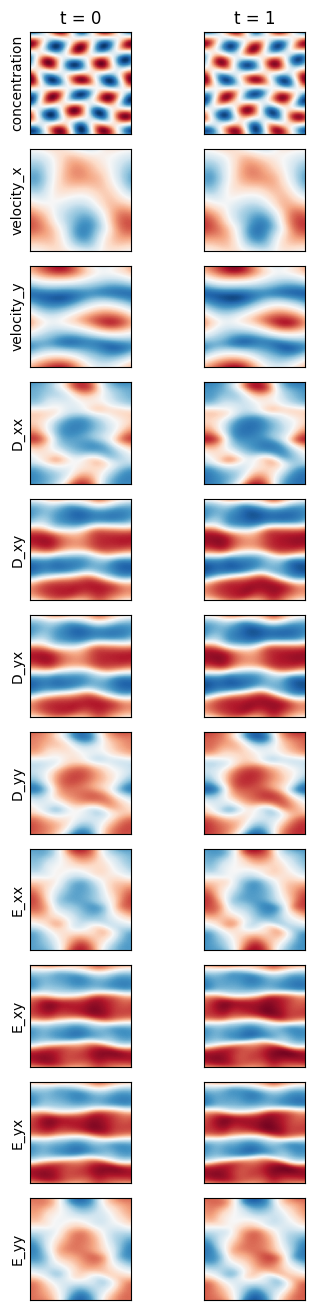

In [82]:
x = dataset[42]["input_fields"]                 # (T, Lx, Ly, F)
x = rearrange(x, "T Lx Ly F -> F T Lx Ly")      # (F, T, Lx, Ly)


#idx = np.arange(N)

F, T, Lx, Ly = x.shape
T = 2

fig, axs = plt.subplots(F, T, figsize=(T * 2.2, F * 1.2))
if F == 1:   axs = np.array([axs])              # normaliza shape si F=1
if T == 1:   axs = axs.reshape(F, 1)

for field in range(F):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])
    axs[field, 0].set_ylabel(f"{field_names[field]}")
    for t in range(T):
        axs[field, t].imshow(x[field, t], cmap="RdBu_r",
                             interpolation="none", vmin=vmin, vmax=vmax)
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])
        if field == 0:
            axs[0, t].set_title(f"t = {t}")

plt.tight_layout()


/tmp/ipykernel_7061/1844463136.py:59: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self.scalar_keys = [f"s{i}" for i in range(np.array(scal).ravel().shape[0])]
/tmp/ipykernel_7061/1844463136.py:83: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  vals = np.array(scal, dtype=np.float32).ravel()


Device: cuda
Entrada al AE: C=110 (= T*F), H=256, W=256


Epoch 1/50: 100%|██████████| 394/394 [06:38<00:00,  1.01s/it]


  -> train MSE: 0.169986


Epoch 2/50: 100%|██████████| 394/394 [06:50<00:00,  1.04s/it]


  -> train MSE: 0.152808


Epoch 3/50: 100%|██████████| 394/394 [06:41<00:00,  1.02s/it]


  -> train MSE: 0.147296


Epoch 4/50: 100%|██████████| 394/394 [06:51<00:00,  1.04s/it]


  -> train MSE: 0.145247


Epoch 5/50: 100%|██████████| 394/394 [09:46<00:00,  1.49s/it]  


  -> train MSE: 0.144017


Epoch 6/50: 100%|██████████| 394/394 [07:02<00:00,  1.07s/it]


  -> train MSE: 0.143264


Epoch 7/50: 100%|██████████| 394/394 [06:51<00:00,  1.04s/it]


  -> train MSE: 0.142668


Epoch 8/50: 100%|██████████| 394/394 [07:05<00:00,  1.08s/it]


  -> train MSE: 0.142224


Epoch 9/50: 100%|██████████| 394/394 [07:07<00:00,  1.09s/it]


  -> train MSE: 0.141873


Epoch 10/50: 100%|██████████| 394/394 [06:41<00:00,  1.02s/it]


  -> train MSE: 0.141590


Epoch 11/50: 100%|██████████| 394/394 [06:55<00:00,  1.05s/it]


  -> train MSE: 0.141373


Epoch 12/50: 100%|██████████| 394/394 [09:21<00:00,  1.42s/it]  


  -> train MSE: 0.141116


Epoch 13/50: 100%|██████████| 394/394 [06:44<00:00,  1.03s/it]


  -> train MSE: 0.140975


Epoch 14/50: 100%|██████████| 394/394 [06:56<00:00,  1.06s/it]


  -> train MSE: 0.140758


Epoch 15/50: 100%|██████████| 394/394 [07:43<00:00,  1.18s/it]


  -> train MSE: 0.140587


Epoch 16/50: 100%|██████████| 394/394 [06:58<00:00,  1.06s/it]


  -> train MSE: 0.140425


Epoch 17/50: 100%|██████████| 394/394 [07:17<00:00,  1.11s/it]


  -> train MSE: 0.140287


Epoch 18/50: 100%|██████████| 394/394 [09:22<00:00,  1.43s/it]


  -> train MSE: 0.140165


Epoch 19/50: 100%|██████████| 394/394 [06:53<00:00,  1.05s/it]


  -> train MSE: 0.140051


Epoch 20/50: 100%|██████████| 394/394 [06:58<00:00,  1.06s/it]


  -> train MSE: 0.139921


Epoch 21/50: 100%|██████████| 394/394 [06:50<00:00,  1.04s/it]


  -> train MSE: 0.139824


Epoch 22/50: 100%|██████████| 394/394 [07:06<00:00,  1.08s/it]


  -> train MSE: 0.139703


Epoch 23/50: 100%|██████████| 394/394 [07:37<00:00,  1.16s/it]


  -> train MSE: 0.139654


Epoch 24/50: 100%|██████████| 394/394 [07:47<00:00,  1.19s/it] 


  -> train MSE: 0.139538


Epoch 25/50: 100%|██████████| 394/394 [09:53<00:00,  1.51s/it]


  -> train MSE: 0.139489


Epoch 26/50: 100%|██████████| 394/394 [06:53<00:00,  1.05s/it]


  -> train MSE: 0.139387


Epoch 27/50: 100%|██████████| 394/394 [06:52<00:00,  1.05s/it]


  -> train MSE: 0.139310


Epoch 28/50: 100%|██████████| 394/394 [07:26<00:00,  1.13s/it]


  -> train MSE: 0.139281


Epoch 29/50: 100%|██████████| 394/394 [07:14<00:00,  1.10s/it]


  -> train MSE: 0.139213


Epoch 30/50: 100%|██████████| 394/394 [07:36<00:00,  1.16s/it]


  -> train MSE: 0.139115


Epoch 31/50: 100%|██████████| 394/394 [07:07<00:00,  1.08s/it]


  -> train MSE: 0.139106


Epoch 32/50: 100%|██████████| 394/394 [10:07<00:00,  1.54s/it]  


  -> train MSE: 0.139080


Epoch 33/50: 100%|██████████| 394/394 [06:48<00:00,  1.04s/it]


  -> train MSE: 0.138979


Epoch 34/50: 100%|██████████| 394/394 [07:30<00:00,  1.14s/it]


  -> train MSE: 0.138933


Epoch 35/50: 100%|██████████| 394/394 [06:54<00:00,  1.05s/it]


  -> train MSE: 0.138914


Epoch 36/50: 100%|██████████| 394/394 [06:48<00:00,  1.04s/it]


  -> train MSE: 0.138849


Epoch 37/50: 100%|██████████| 394/394 [06:47<00:00,  1.04s/it]


  -> train MSE: 0.138844


Epoch 38/50: 100%|██████████| 394/394 [06:56<00:00,  1.06s/it]


  -> train MSE: 0.138773


Epoch 39/50: 100%|██████████| 394/394 [09:55<00:00,  1.51s/it] 


  -> train MSE: 0.138827


Epoch 40/50: 100%|██████████| 394/394 [07:15<00:00,  1.10s/it]


  -> train MSE: 0.138659


Epoch 41/50: 100%|██████████| 394/394 [06:54<00:00,  1.05s/it]


  -> train MSE: 0.138658


Epoch 42/50: 100%|██████████| 394/394 [07:18<00:00,  1.11s/it]


  -> train MSE: 0.138705


Epoch 43/50: 100%|██████████| 394/394 [07:44<00:00,  1.18s/it]


  -> train MSE: 0.138567


Epoch 44/50: 100%|██████████| 394/394 [06:56<00:00,  1.06s/it]


  -> train MSE: 0.138677


Epoch 45/50: 100%|██████████| 394/394 [09:37<00:00,  1.47s/it]


  -> train MSE: 0.138556


Epoch 46/50: 100%|██████████| 394/394 [07:19<00:00,  1.11s/it]


  -> train MSE: 0.138514


Epoch 47/50: 100%|██████████| 394/394 [07:13<00:00,  1.10s/it]


  -> train MSE: 0.138494


Epoch 48/50: 100%|██████████| 394/394 [07:02<00:00,  1.07s/it]


  -> train MSE: 0.138547


Epoch 49/50: 100%|██████████| 394/394 [07:01<00:00,  1.07s/it]


  -> train MSE: 0.138461


Epoch 50/50: 100%|██████████| 394/394 [06:58<00:00,  1.06s/it]


  -> train MSE: 0.138439


100%|██████████| 197/197 [05:56<00:00,  1.81s/it]


Latent Z shape: (12600, 8)
Scalars shape: (12600, 3)


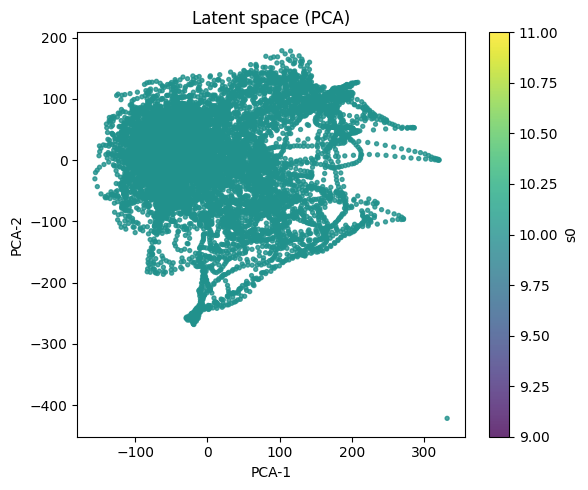

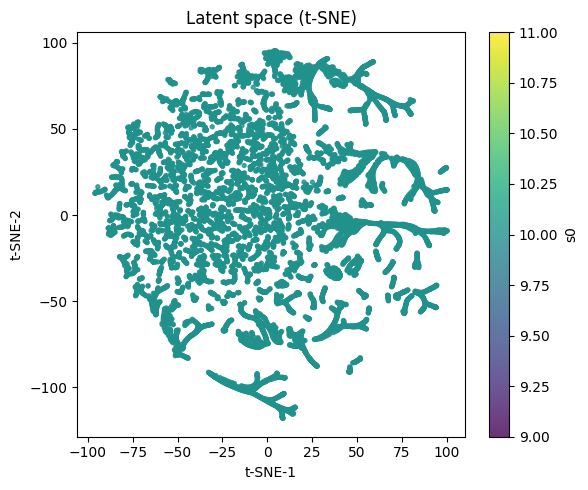

Guardado en ./ae_outputs/


In [83]:
# ==== 0) Imports y utilidades ====
import os, math, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from einops import rearrange
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reproducibilidad
def set_seed(s=42):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ==== 1) Dataset THE WELL ya creado por ti ====
# Supongo que ya lo tienes tal cual:
# from the_well.data import WellDataset  # <- según tu instalación
# dataset = WellDataset(
#     well_base_path="/home/itachi/Desktop/msc/data/datasets",
#     well_dataset_name="active_matter",
#     well_split_name="train",
#     n_steps_input=10,
#     n_steps_output=0,
#     use_normalization=True,
# )

# Para este pipeline, lo único que necesitamos es saber cómo transformar cada item
# item["input_fields"] tiene shape (T, Lx, Ly, F)

class WellToTensorDataset(Dataset):
    """
    Envuelve el WellDataset y convierte cada muestra a tensores PyTorch listos
    para un autoencoder 2D apilando tiempo y campos como canales: (C, H, W) con C=T*F.
    Guarda, si existen, 'constant_scalars' para poder colorear el scatter del latente.
    """
    def __init__(self, base_dataset):
        self.base = base_dataset

        # Inspecciona una muestra para fijar shapes
        sample = self.base[0]
        x = sample["input_fields"]             # (T, Lx, Ly, F)
        self.T, self.Lx, self.Ly, self.F = x.shape

        # Detecta si hay escalars constantes (parámetros de control)
        self.has_scalars = "constant_scalars" in sample
        if self.has_scalars:
            # sample["constant_scalars"] suele ser dict o array; homogenizamos a 1D np.array
            scal = sample["constant_scalars"]
            if isinstance(scal, dict):
                self.scalar_keys = list(scal.keys())
            else:
                self.scalar_keys = [f"s{i}" for i in range(np.array(scal).ravel().shape[0])]
        else:
            self.scalar_keys = []

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        item = self.base[idx]
        x = item["input_fields"]  # (T, Lx, Ly, F), float32/float64 numpy

        # Rearr: (T, Lx, Ly, F) -> (F, T, Lx, Ly) -> (C, Lx, Ly) con C=T*F
        x = rearrange(x, "T Lx Ly F -> F T Lx Ly")
        x = rearrange(x, "F T Lx Ly -> (F T) Lx Ly")  # canales = T * F
        x = torch.as_tensor(x, dtype=torch.float32)

        out = {"x": x}

        # Adjunta scalars si existen (para colorear el espacio latente)
        if self.has_scalars:
            scal = item["constant_scalars"]
            if isinstance(scal, dict):
                vals = np.array([scal[k] for k in self.scalar_keys], dtype=np.float32).ravel()
            else:
                vals = np.array(scal, dtype=np.float32).ravel()
            out["scalars"] = torch.from_numpy(vals)
        else:
            out["scalars"] = None

        return out

# ==== 2) DataLoaders ====
# Si tienes splits adicionales (val/test) crea más wrappers. Aquí solo train por simplicidad.
wrap = WellToTensorDataset(dataset)
C, H, W = wrap[0]["x"].shape
print(f"Entrada al AE: C={C} (= T*F), H={H}, W={W}")

train_loader = DataLoader(wrap, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# ==== 3) Modelo: Autoencoder convolucional ====
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels, latent_dim=8):
        super().__init__()
        # Encoder: baja HxW con stride=2 dos veces (64->32->16 si H=W=64)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),  # H/2
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # H/4
            nn.ReLU(inplace=True),
        )
        # Proyección a latente
        # Asumimos H y W potencias de 2 (p.ej., 64->16 tras dos downsamplings)
        self.enc_out_hw = (H // 4, W // 4)
        self.enc_flat_dim = 128 * self.enc_out_hw[0] * self.enc_out_hw[1]
        self.to_latent = nn.Linear(self.enc_flat_dim, latent_dim)

        # Decoder inverso
        self.from_latent = nn.Linear(latent_dim, self.enc_flat_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # H/2
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1), # H
            nn.Sigmoid(),  # datos normalizados (0-1 aprox). Si no, sustituye por nn.Identity()
        )

    def encode(self, x):
        h = self.encoder(x)                            # (B,128,H/4,W/4)
        h = h.view(h.size(0), -1)                      # flatten
        z = self.to_latent(h)                          # (B,latent_dim)
        return z

    def decode(self, z):
        h = self.from_latent(z)                        # (B,128*H/4*W/4)
        h = h.view(-1, 128, self.enc_out_hw[0], self.enc_out_hw[1])
        xrec = self.decoder(h)                         # (B,C,H,W)
        return xrec

    def forward(self, x):
        z = self.encode(x)
        xrec = self.decode(z)
        return xrec, z

latent_dim = 8
model = ConvAutoencoder(in_channels=C, latent_dim=latent_dim).to(device)

# ==== 4) Entrenamiento ====
criterion = nn.MSELoss()  # reconstrucción
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

epochs = 50
model.train()
for epoch in range(1, epochs+1):
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        x = batch["x"].to(device, non_blocking=True)    # (B,C,H,W)
        optimizer.zero_grad()
        xrec, z = model(x)
        loss = criterion(xrec, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"  -> train MSE: {epoch_loss:.6f}")

# ==== 5) Extracción del espacio latente (modo evaluación) ====
model.eval()
all_z = []
all_scalars = []
with torch.no_grad():
    for batch in tqdm(DataLoader(wrap, batch_size=64, shuffle=False, num_workers=2)):
        x = batch["x"].to(device, non_blocking=True)
        z = model.encode(x)                 # (B, latent_dim)
        all_z.append(z.cpu().numpy())
        if batch["scalars"] is not None:
            all_scalars.append(batch["scalars"].numpy())

Z = np.concatenate(all_z, axis=0)  # (N_samples, latent_dim)
print("Latent Z shape:", Z.shape)

if len(all_scalars) > 0:
    SC = np.concatenate(all_scalars, axis=0)  # (N_samples, n_scalars)
    print("Scalars shape:", SC.shape)
else:
    SC = None
    print("No se encontraron constant_scalars; colorearemos por índice.")

# ==== 6) Reducción de dimensionalidad y visualización (PCA y t-SNE) ====
# PCA (2D)
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(Z)

# t-SNE (opcional, más lento; puedes comentar si no lo necesitas)
try:
    Z_tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=30, random_state=42).fit_transform(Z)
    has_tsne = True
except Exception as e:
    print("t-SNE no disponible o falló:", e)
    has_tsne = False

# Colorear por primer escalar si existe; si no, por índice
if SC is not None and SC.ndim == 2 and SC.shape[1] >= 1:
    color = SC[:, 0]
    c_label = (wrap.scalar_keys[0] if len(wrap.scalar_keys) > 0 else "scalar_0")
else:
    color = np.arange(Z.shape[0])
    c_label = "index"

# Plots
plt.figure(figsize=(6,5))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=color, s=8, alpha=0.8)
plt.xlabel("PCA-1"); plt.ylabel("PCA-2"); plt.title("Latent space (PCA)")
cbar = plt.colorbar()
cbar.set_label(c_label)
plt.tight_layout()
plt.show()

if has_tsne:
    plt.figure(figsize=(6,5))
    plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=color, s=8, alpha=0.8)
    plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2"); plt.title("Latent space (t-SNE)")
    cbar = plt.colorbar()
    cbar.set_label(c_label)
    plt.tight_layout()
    plt.show()

# ==== 7) Guardados opcionales ====
os.makedirs("ae_outputs", exist_ok=True)
torch.save(model.state_dict(), "ae_outputs/convAE.pt")
np.save("ae_outputs/Z_latent.npy", Z)
if SC is not None:
    np.save("ae_outputs/scalars.npy", SC)
print("Guardado en ./ae_outputs/")

✅ Device: NVIDIA GeForce RTX 4060 Ti
Entrada AE3D (submuestreado): F=11, T=9, H=256, W=256


Epoch 1/30: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


→ epoch 1: MSE 0.166790


Epoch 2/30: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


→ epoch 2: MSE 0.151049


Epoch 3/30: 100%|██████████| 88/88 [00:28<00:00,  3.05it/s]


→ epoch 3: MSE 0.150669


Epoch 4/30: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


→ epoch 4: MSE 0.150507


Epoch 5/30: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


→ epoch 5: MSE 0.150420


Epoch 6/30: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


→ epoch 6: MSE 0.150393


Epoch 7/30: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


→ epoch 7: MSE 0.150434


Epoch 8/30: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


→ epoch 8: MSE 0.150418


Epoch 9/30: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


→ epoch 9: MSE 0.150334


Epoch 10/30: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]


→ epoch 10: MSE 0.150371


Epoch 11/30: 100%|██████████| 88/88 [00:28<00:00,  3.13it/s]


→ epoch 11: MSE 0.150321


Epoch 12/30: 100%|██████████| 88/88 [00:28<00:00,  3.09it/s]


→ epoch 12: MSE 0.150351


Epoch 13/30: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


→ epoch 13: MSE 0.150364


Epoch 14/30: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]


→ epoch 14: MSE 0.150333


Epoch 15/30: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


→ epoch 15: MSE 0.150323


Epoch 16/30: 100%|██████████| 88/88 [00:31<00:00,  2.84it/s]


→ epoch 16: MSE 0.150342


Epoch 17/30: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]


→ epoch 17: MSE 0.150356


Epoch 18/30: 100%|██████████| 88/88 [00:31<00:00,  2.76it/s]


→ epoch 18: MSE 0.150327


Epoch 19/30: 100%|██████████| 88/88 [00:31<00:00,  2.81it/s]


→ epoch 19: MSE 0.150315


Epoch 20/30: 100%|██████████| 88/88 [00:30<00:00,  2.85it/s]


→ epoch 20: MSE 0.150328


Epoch 21/30: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


→ epoch 21: MSE 0.150290


Epoch 22/30: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]


→ epoch 22: MSE 0.150309


Epoch 23/30: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


→ epoch 23: MSE 0.150233


Epoch 24/30: 100%|██████████| 88/88 [00:28<00:00,  3.08it/s]


→ epoch 24: MSE 0.150226


Epoch 25/30: 100%|██████████| 88/88 [00:28<00:00,  3.07it/s]


→ epoch 25: MSE 0.150206


Epoch 26/30: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


→ epoch 26: MSE 0.150230


Epoch 27/30: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


→ epoch 27: MSE 0.150204


Epoch 28/30: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


→ epoch 28: MSE 0.150183


Epoch 29/30: 100%|██████████| 88/88 [00:31<00:00,  2.77it/s]


→ epoch 29: MSE 0.150224


Epoch 30/30: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s]


→ epoch 30: MSE 0.150218


100%|██████████| 88/88 [00:32<00:00,  2.74it/s]

Latent Z shape: (175, 8)
PCA explained var: [0.84351707 0.10781967]


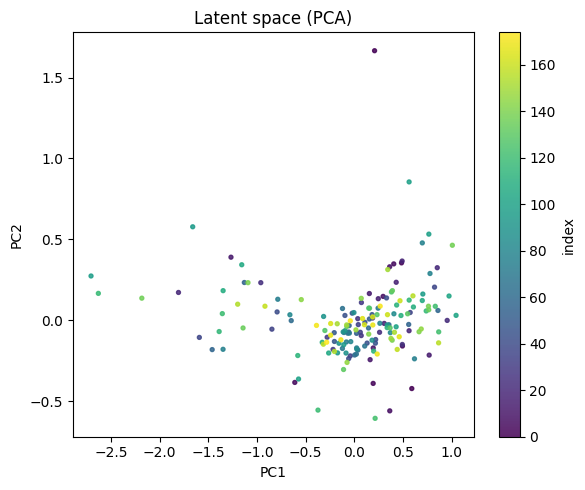

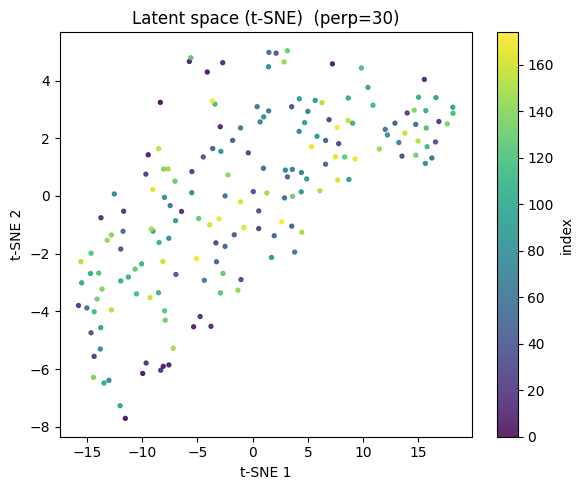

Guardado: ae_outputs/Z_latent.npy, Z_pca.npy, Z_tsne.npy


In [86]:
# ------------------------------------------------------------
# 0) Imports y device (igual que tienes)
# ------------------------------------------------------------
import os, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from einops import rearrange
from tqdm import tqdm
from the_well.data import WellDataset

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
if use_cuda:
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass
    print(f"✅ Device: {torch.cuda.get_device_name(0)}")
else:
    print("✅ Device: CPU")

# ------------------------------------------------------------
# 1) Carga del dataset base (81 steps en el split)
# ------------------------------------------------------------
dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=81,   # cargamos todos para luego submuestrear
    n_steps_output=0,
    use_normalization=True,
)

# ------------------------------------------------------------
# 2) Wrapper: submuestrea tiempo cada 9 → T_final = 9; (T,H,W,F)->(F,T,H,W)
# ------------------------------------------------------------
class WellToTensor3DSubsample(torch.utils.data.Dataset):
    """
    - Toma el item["input_fields"] con shape (T, H, W, F).
    - Selecciona 9 pasos de tiempo espaciados cada 'step' (=9 por defecto).
    - Reordena a (F, T_keep, H, W) para Conv3d (F = canales).
    """
    def __init__(self, base, step=20, n_keep=4):
        self.base = base
        self.step = step
        self.n_keep = n_keep

        s = self.base[0]["input_fields"]          # (T,H,W,F)
        self.T_full, self.H, self.W, self.F = s.shape

        # índices: 0, step, 2*step, ... hasta n_keep pasos
        self.time_idx = np.arange(0, step*n_keep, step)
        assert self.time_idx[-1] < self.T_full, \
            f"Necesitas T_full >= {step*(n_keep-1)+1}; tienes T_full={self.T_full}"

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        item = self.base[idx]
        x = item["input_fields"]                  # (T,H,W,F)
        x = x[self.time_idx]                      # (T_keep,H,W,F) con T_keep=9
        x = rearrange(x, "T H W F -> F T H W")    # (F,T,H,W)
        x = torch.as_tensor(x, dtype=torch.float32)
        return {"x": x}

wrap = WellToTensor3DSubsample(dataset, step=9, n_keep=9)
F, T, H, W = wrap[0]["x"].shape   # F=11, T=9, H=W=256
print(f"Entrada AE3D (submuestreado): F={F}, T={T}, H={H}, W={W}")

# ------------------------------------------------------------
# 3) Autoencoder 3D: solo downsampling ESPACIAL (no temporal)
#    256 -> 128 -> 64 -> 32 en H,W; T=9 se mantiene
# ------------------------------------------------------------
class ConvAE3D_T9(nn.Module):
    """
    Encoder:
      (F, 9, 256, 256)
        -> (64, 9, 128,128)   stride=(1,2,2)
        -> (128,9, 64, 64)    stride=(1,2,2)
        -> (256,9, 32, 32)    stride=(1,2,2)
      GAP3D -> (256,) -> Linear -> z

    Decoder (inverso, sin cambiar T):
      z -> Linear -> (256,9,32,32)
        -> (128,9,64,64)      ConvT3d stride=(1,2,2)
        -> (64, 9,128,128)    ConvT3d stride=(1,2,2)
        -> (F,  9,256,256)    ConvT3d stride=(1,2,2)
    """
    def __init__(self, in_channels=11, latent_dim=8):
        super().__init__()
        # Encoder (sin downsample temporal)
        self.enc = nn.Sequential(
            nn.Conv3d(in_channels, 64,  kernel_size=3, stride=(1,2,2), padding=1),
            nn.BatchNorm3d(64),  nn.ReLU(inplace=True),

            nn.Conv3d(64, 128,   kernel_size=3, stride=(1,2,2), padding=1),
            nn.BatchNorm3d(128), nn.ReLU(inplace=True),

            nn.Conv3d(128, 256,  kernel_size=3, stride=(1,2,2), padding=1),
            nn.BatchNorm3d(256), nn.ReLU(inplace=True),
        )
        # 256x256 -> 32x32; T=9 sin cambios
        self.gap = nn.AdaptiveAvgPool3d((1,1,1))   # (B,256,1,1,1)
        self.to_latent = nn.Linear(256, latent_dim)

        # Decoder
        self.from_latent = nn.Linear(latent_dim, 256)

        self.dec = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=(1,2,2),
                               padding=1, output_padding=(0,1,1)),  # 32->64
            nn.BatchNorm3d(128), nn.ReLU(inplace=True),

            nn.ConvTranspose3d(128, 64,  kernel_size=3, stride=(1,2,2),
                               padding=1, output_padding=(0,1,1)),  # 64->128
            nn.BatchNorm3d(64),  nn.ReLU(inplace=True),

            nn.ConvTranspose3d(64,  in_channels, kernel_size=3, stride=(1,2,2),
                               padding=1, output_padding=(0,1,1)),  # 128->256
            nn.Identity(),  # datos ~ z-score (use_normalization=True)
        )

    def encode(self, x):                 # x: (B,F,9,256,256)
        h = self.enc(x)                  # (B,256,9,32,32)
        g = self.gap(h).flatten(1)       # (B,256)
        z = self.to_latent(g)            # (B,latent_dim)
        return z

    def decode(self, z):
        b = z.shape[0]
        g = self.from_latent(z)          # (B,256)
        h = g.view(b, 256, 1, 1, 1).expand(b, 256, 9, 32, 32)  # (B,256,9,32,32)
        xrec = self.dec(h)               # (B,F,9,256,256)
        return xrec

    def forward(self, x):
        z = self.encode(x)
        xrec = self.decode(z)
        return xrec, z

model = ConvAE3D_T9(in_channels=F, latent_dim=8).to(device)

# ------------------------------------------------------------
# 4) Entrenamiento
# ------------------------------------------------------------
batch_size = 2 if use_cuda else 1
train_loader = DataLoader(wrap, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=use_cuda)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

epochs = 30
model.train()
for ep in range(1, epochs+1):
    running = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
        x = batch["x"].to(device, non_blocking=True)   # (B,F,9,256,256)
        optimizer.zero_grad()
        xrec, z = model(x)
        loss = criterion(xrec, x)
        loss.backward()
        optimizer.step()
        running += loss.item() * x.size(0)
    print(f"→ epoch {ep}: MSE {running/len(train_loader.dataset):.6f}")

# ------------------------------------------------------------
# 5) Extraer latente (PCA/t-SNE opcional)
# ------------------------------------------------------------
model.eval()
Z = []
with torch.no_grad():
    for batch in tqdm(DataLoader(wrap, batch_size=batch_size, shuffle=False,
                                 num_workers=2, pin_memory=use_cuda)):
        x = batch["x"].to(device, non_blocking=True)
        z = model.encode(x)
        Z.append(z.cpu().numpy())
Z = np.concatenate(Z, axis=0)
print("Latent Z shape:", Z.shape)




# ------------------------------------------------------------
# 6) PCA y t-SNE sobre el espacio latente Z
# ------------------------------------------------------------
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Color de referencia (si no tienes scalars, usamos el índice)
color = np.arange(Z.shape[0])
c_label = "index"

# --- PCA (2D)
pca = PCA(n_components=2, random_state=42)
Z_pca = pca.fit_transform(Z)
print(f"PCA explained var: {pca.explained_variance_ratio_}")

plt.figure(figsize=(6,5))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=color, s=8, alpha=0.85)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Latent space (PCA)")
cbar = plt.colorbar()
cbar.set_label(c_label)
plt.tight_layout()
plt.show()

# --- t-SNE (2D)
# Perplejidad segura según N (regla práctica)
N = Z.shape[0]
perp = max(5, min(30, (N - 1) // 3))  # evita error cuando N es pequeño

tsne = TSNE(
    n_components=2,
    init="pca",
    learning_rate="auto",
    perplexity=perp,
    random_state=42,
)
Z_tsne = tsne.fit_transform(Z)

plt.figure(figsize=(6,5))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=color, s=8, alpha=0.85)
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.title(f"Latent space (t-SNE)  (perp={perp})")
cbar = plt.colorbar()
cbar.set_label(c_label)
plt.tight_layout()
plt.show()

# --- Guardados opcionales
os.makedirs("ae_outputs", exist_ok=True)
np.save("ae_outputs/Z_latent.npy", Z)
np.save("ae_outputs/Z_pca.npy", Z_pca)
np.save("ae_outputs/Z_tsne.npy", Z_tsne)
print("Guardado: ae_outputs/Z_latent.npy, Z_pca.npy, Z_tsne.npy")

IndexError: list index out of range